In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from kymatio.torch import Scattering2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
args = {
    'learning_rate': 1e-3,
    'batch_size': 256,
    'num_worker': 32,
    'random_seed': 8771795,
    'augmentation': False,
    'num_epoch': 10,
    'device': 'cuda'
}

In [3]:
# Set random seed
torch.random.manual_seed(args['random_seed'])

# Define transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_valid_transform = test_transform
if args['augmentation']:
    train_valid_transform = transforms.Compose([
        transforms.RandomResizedCrop((28,28)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Load dataset
require_download = os.path.exists('./dataset')
train_valid_dataset = torchvision.datasets.FashionMNIST('./dataset', train=True, transform=train_valid_transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./dataset', train=False, transform=test_transform, download=True)

# Split train and validation
torch.random.manual_seed(args['random_seed'])
train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [54000, 6000])

# Generate dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_worker'])
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=args['num_worker'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=args['num_worker'])

In [4]:
def calculate_stats(feats, labels):
    feats = feats.view(feats.shape[0], -1)

    # Global variable
    unique_classes = labels.unique()
    num_classes = unique_classes.shape[0]
    feat_size = feats.shape[-1]

    # Global mean
    global_mean = feats.mean(dim=0)

    # Per class stats
    class_means = torch.zeros(num_classes, feat_size).to(feats.device)
    class_covariance_matrices = torch.zeros(num_classes, feat_size, feat_size).to(feats.device)
    within_class_covariances = torch.zeros(num_classes, feat_size, feat_size).to(feats.device)
    for i, label in enumerate(unique_classes):
        class_feats = feats[labels == label]
        class_size = class_feats.shape[0]
        class_mean = class_feats.mean(dim=0)

        class_means[i,...] = class_mean
        class_covariance_matrices[i,...] = torch.mm((class_feats - global_mean).T, (class_feats - global_mean)) / class_size
        within_class_covariances[i,...] = torch.mm((class_feats - class_mean).T, (class_feats - class_mean)) / class_size

    # Total class covariance
    total_class_covariances = class_covariance_matrices.mean(dim=0)

    # Within class covariance
    within_class_covariances = within_class_covariances.mean(dim=0)
    
    # Between class covariance
    between_class_covariances = torch.mm((class_means - global_mean).T, (class_means - global_mean)) / num_classes

    # Contraction of within class variation
    contraction = torch.trace(within_class_covariances.mm(between_class_covariances.T)) / num_classes
    
    # Class distances to global mean
    class_distances = (class_means - global_mean).norm(2, dim=1)

    # Class closeness
    closeness = class_distances.std() / class_distances.mean()

    # Class angularity
    cos_c2c = torch.mm((class_means - global_mean), (class_means - global_mean).T) / (class_distances * class_distances)
    equal_angularity = cos_c2c.std()
    
    # Maximal-angle equiangularity
    num_pairs = (num_classes * (num_classes - 1)) // 2
    for i in range(num_classes):
        cos_c2c[i:, i] = 0
        cos_c2c[i, i+1:] += 1
    closeness_max_angularity = (cos_c2c / (num_classes - 1)).sum() / num_pairs
    
    return (
        global_mean, class_means, 
        total_class_covariances, within_class_covariances, between_class_covariances,
        contraction, closeness, equal_angularity, closeness_max_angularity
    )

In [5]:
def print_stats(stats):
    (
        global_mean, class_means, 
        total_class_covariances, within_class_covariances, between_class_covariances,
        contraction, closeness, equal_angularity, closeness_max_angularity
    ) = stats
    
    print(f'global mean : {global_mean}')
    print(f'per class mean : {class_means}')
    print(f'ΣT : {total_class_covariances}')
    print(f'ΣW + ΣB : {(within_class_covariances + between_class_covariances)}')
    print(f'ΣT - (ΣW + ΣB) : {(total_class_covariances - (within_class_covariances + between_class_covariances)).norm(2)}')
    print(f'contraction of within class variation : {contraction}')
    print(f'closeness to equal-norms of class-means : {closeness}')
    print(f'equal-angularity : {equal_angularity}')
    print(f'closeness to maximal-angle equiangularity : {closeness_max_angularity}')

In [6]:
if not os.path.exists('./features'):
    os.mkdir('./features')
if not os.path.exists('./stats'):
    os.mkdir('./stats')
    
train_contractions, valid_contractions, test_contractions = [], [], []
train_closenesses, valid_closenesses, test_closenesses = [], [], []
train_eq_angularities, valid_eq_angularities, test_eq_angularities = [], [], []
train_closeness_max_angularities, valid_closeness_max_angularities, test_closeness_max_angularities = [], [], []
for j in range(1,5):
    train_feats, valid_feats, test_feats = [], [], []
    train_labels, valid_labels, test_labels = [], [], []
    train_stats, valid_stats, test_stats = [], [], []    
    model = Scattering2D(J=j, shape=(28, 28)).to(args['device'])

    # Train
    for x, y in tqdm(train_loader):
        x, y = x.to(args['device']), y.to(args['device'])
        yp = model(x) 
        train_feats.append(yp)
        train_labels.append(y)
    train_feats = torch.cat(train_feats, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    train_stats = calculate_stats(train_feats, train_labels)

    # Valid
    for x, y in tqdm(valid_loader):
        x, y = x.to(args['device']), y.to(args['device'])
        yp = model(x)
        valid_feats.append(yp)
        valid_labels.append(y)
    valid_feats = torch.cat(valid_feats, dim=0)
    valid_labels = torch.cat(valid_labels, dim=0)
    valid_stats = calculate_stats(valid_feats, valid_labels)

    # Test
    for x, y in tqdm(test_loader):
        x, y = x.to(args['device']), y.to(args['device'])
        yp = model(x)
        test_feats.append(yp)
        test_labels.append(y)
    test_feats = torch.cat(test_feats, dim=0)
    test_labels = torch.cat(test_labels, dim=0)
    test_stats = calculate_stats(test_feats, test_labels)
    
    torch.save((train_feats, train_labels, valid_feats, valid_labels, test_feats, test_labels), open(f'./features/scaterring_J{j}.pt', 'wb'))
    torch.save((train_stats, valid_stats, test_stats), open(f'./stats/scaterring_J{j}.pt', 'wb'))
    
    print(f'== Scaterring J{j} ==')
    
    print('= Train Stats =')
    print_stats(train_stats)
    
    print('= Valid Stats =')
    print_stats(valid_stats)
    
    print('= Test Stats =')
    print_stats(test_stats)
    
    _, _, _, _, _, train_contraction, train_closeness, train_equal_angularity, train_closeness_max_angularity = train_stats
    _, _, _, _, _, valid_contraction, valid_closeness, valid_equal_angularity, valid_closeness_max_angularity = valid_stats
    _, _, _, _, _, test_contraction, test_closeness, test_equal_angularity, test_closeness_max_angularity = test_stats
    
    train_contractions.append(train_contraction.item())
    valid_contractions.append(valid_contraction.item())
    test_contractions.append(test_contraction.item())
    
    train_closenesses.append(train_closeness.item())
    valid_closenesses.append(valid_closeness.item())
    test_closenesses.append(test_closeness.item())
    
    train_eq_angularities.append(train_equal_angularity.item())
    valid_eq_angularities.append(valid_equal_angularity.item())
    test_eq_angularities.append(test_equal_angularity.item())
    
    train_closeness_max_angularities.append(train_closeness_max_angularity.item())
    valid_closeness_max_angularities.append(valid_closeness_max_angularity.item())
    test_closeness_max_angularities.append(test_closeness_max_angularity.item())


  0%|          | 0/211 [00:00<?, ?it/s]

== Scaterring J1 ==
= Train Stats =
global mean : tensor([-0.9999, -0.9991, -0.9935,  ...,  0.0735,  0.0469,  0.0232],
       device='cuda:0')
per class mean : tensor([[-9.9984e-01, -9.9770e-01, -9.8155e-01,  ...,  1.0093e-01,
          1.4542e-02,  1.9617e-03],
        [-1.0000e+00, -9.9994e-01, -9.9781e-01,  ...,  1.0779e-02,
          2.8926e-03,  6.7308e-04],
        [-9.9997e-01, -9.9925e-01, -9.9017e-01,  ...,  2.1234e-01,
          1.4592e-01,  4.4488e-02],
        ...,
        [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ...,  1.6606e-04,
          2.2313e-04,  7.3242e-04],
        [-9.9941e-01, -9.9699e-01, -9.8768e-01,  ...,  4.1191e-02,
          4.6283e-02,  4.1390e-02],
        [-9.9996e-01, -9.9990e-01, -9.9983e-01,  ...,  3.1385e-02,
          2.6619e-02,  5.2043e-02]], device='cuda:0')
ΣT : tensor([[1.6504e-05, 2.6030e-05, 2.1094e-05,  ..., 4.7085e-07, 2.9843e-06,
         6.3945e-06],
        [2.6030e-05, 1.9604e-04, 4.2959e-04,  ..., 2.1148e-05, 3.1398e-05,
         3.825

100%|██████████| 40/40 [00:01<00:00, 23.36it/s]


== Scaterring J2 ==
= Train Stats =
global mean : tensor([-0.9984, -0.9638, -0.6988,  ...,  0.0174,  0.0314,  0.0239],
       device='cuda:0')
per class mean : tensor([[-9.9646e-01, -8.7378e-01, -3.1673e-01,  ...,  1.4529e-02,
          4.9181e-02,  2.5214e-02],
        [-9.9992e-01, -9.9173e-01, -6.1450e-01,  ...,  5.2301e-02,
          4.7951e-02,  7.8987e-03],
        [-9.9860e-01, -9.1024e-01, -3.4733e-01,  ...,  1.6184e-02,
          4.5343e-02,  3.9551e-02],
        ...,
        [-1.0000e+00, -1.0000e+00, -9.9997e-01,  ...,  8.6109e-04,
          9.9979e-04,  4.3340e-03],
        [-9.9380e-01, -9.7332e-01, -9.3102e-01,  ...,  5.4969e-03,
          1.3188e-02,  2.9355e-02],
        [-9.9885e-01, -9.9851e-01, -9.9654e-01,  ...,  8.1167e-03,
          1.8601e-02,  3.1907e-02]], device='cuda:0')
ΣT : tensor([[ 2.0073e-04,  5.6806e-04,  4.9023e-04,  ..., -1.2106e-05,
         -7.8413e-06,  2.0571e-05],
        [ 5.6806e-04,  7.6010e-03,  2.1046e-02,  ..., -9.4594e-05,
          4.5909

100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


== Scaterring J3 ==
= Train Stats =
global mean : tensor([-0.9194, -0.4083, -0.3976,  ...,  0.0332,  0.0322,  0.0337],
       device='cuda:0')
per class mean : tensor([[-0.7831, -0.0190, -0.0521,  ...,  0.0365,  0.0466,  0.0455],
        [-0.9685, -0.0806, -0.1398,  ...,  0.0298,  0.0500,  0.0531],
        [-0.8281,  0.0043, -0.0532,  ...,  0.0618,  0.0431,  0.0445],
        ...,
        [-0.9994, -0.9913, -0.9616,  ...,  0.0056,  0.0039,  0.0067],
        [-0.9036, -0.7292, -0.7288,  ...,  0.0358,  0.0188,  0.0185],
        [-0.9948, -0.9177, -0.5758,  ...,  0.0132,  0.0138,  0.0188]],
       device='cuda:0')
ΣT : tensor([[0.0123, 0.0339, 0.0291,  ..., 0.0012, 0.0007, 0.0006],
        [0.0339, 0.2333, 0.1968,  ..., 0.0085, 0.0087, 0.0083],
        [0.0291, 0.1968, 0.1929,  ..., 0.0071, 0.0074, 0.0072],
        ...,
        [0.0012, 0.0085, 0.0071,  ..., 0.0006, 0.0004, 0.0003],
        [0.0007, 0.0087, 0.0074,  ..., 0.0004, 0.0006, 0.0005],
        [0.0006, 0.0083, 0.0072,  ..., 0.000

100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


== Scaterring J4 ==
= Train Stats =
global mean : tensor([-0.5349,  0.0413,  0.0330,  0.0316,  0.0327,  0.0290,  0.0296,  0.0380,
         0.0483,  0.0609,  0.0483,  0.0423,  0.0433,  0.0374,  0.0419,  0.0548,
         0.0712,  0.0947,  0.0655,  0.0567,  0.0687,  0.0491,  0.0561,  0.0856,
         0.1189,  0.1123,  0.0473,  0.0616,  0.1127,  0.0542,  0.0409,  0.1045,
         0.2081,  0.0123,  0.0085,  0.0056,  0.0039,  0.0033,  0.0046,  0.0082,
         0.0134,  0.0116,  0.0085,  0.0070,  0.0054,  0.0043,  0.0051,  0.0093,
         0.0163,  0.0086,  0.0064,  0.0052,  0.0079,  0.0042,  0.0040,  0.0070,
         0.0144,  0.0082,  0.0080,  0.0069,  0.0050,  0.0033,  0.0031,  0.0048,
         0.0073,  0.0085,  0.0079,  0.0076,  0.0059,  0.0040,  0.0035,  0.0056,
         0.0098,  0.0067,  0.0062,  0.0052,  0.0067,  0.0036,  0.0030,  0.0046,
         0.0092,  0.0056,  0.0071,  0.0084,  0.0077,  0.0049,  0.0036,  0.0037,
         0.0047,  0.0069,  0.0078,  0.0091,  0.0095,  0.0059,  0.0045,

In [7]:
train_feats, train_labels, valid_feats, valid_labels, test_feats, test_labels = torch.load(open(f'./features/scaterring_J1.pt', 'rb'))

In [8]:
train_stats, valid_stats, test_stats = torch.load(open(f'./stats/scaterring_J1.pt', 'rb'))

# Plot

In [9]:
df = pd.DataFrame({
    'J': [i for i in range(1,5)],
    
    'train_contraction': train_contractions,
    'valid_contraction': valid_contractions,
    'test_contraction': test_contractions,
    
    'train_closeness': train_closenesses,
    'valid_closeness': valid_closenesses,
    'test_closeness': test_closenesses,
    
    'train_eq_angularity': train_eq_angularities,
    'valid_eq_angularity': valid_eq_angularities,
    'test_eq_angularity': test_eq_angularities,
    
    'train_closeness_max_angularity': train_closeness_max_angularities,
    'valid_closeness_max_angularity': valid_closeness_max_angularities,
    'test_closeness_max_angularity': test_closeness_max_angularities
})

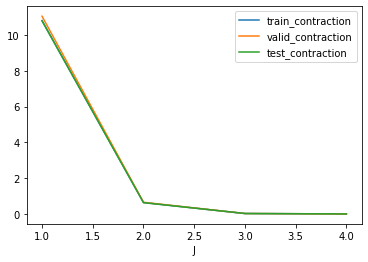

In [10]:
df.plot(x='J', y=['train_contraction', 'valid_contraction', 'test_contraction'])

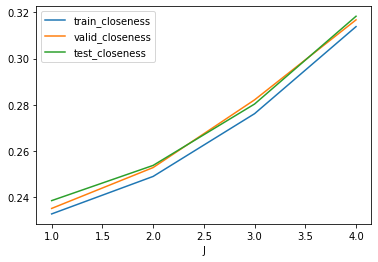

In [11]:
df.plot(x='J', y=['train_closeness', 'valid_closeness', 'test_closeness'])

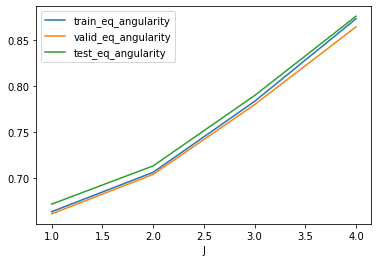

In [12]:
df.plot(x='J', y=['train_eq_angularity', 'valid_eq_angularity', 'test_eq_angularity'])

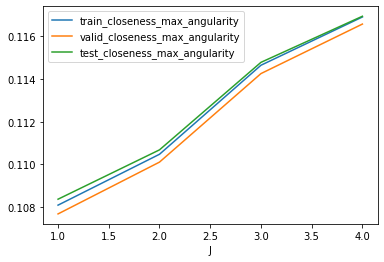

In [13]:
df.plot(x='J', y=['train_closeness_max_angularity', 'valid_closeness_max_angularity', 'test_closeness_max_angularity'])